# 🛠 04. Transfer Learning in TensorFlow Part 1: Feature Extraction Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

2. Name 3 different image classification models on TensorFlow Hub that we haven't used.

3. Build a model to classify images of two different things you've taken photos of.

    * You can use any feature extraction layer from TensorFlow Hub you like for this.

    * You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

4. What is the current best performing model on ImageNet?

In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-12-31 05:34:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.251.18.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.5MB/s    in 4.7s    

2024-12-31 05:34:56 (34.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
mobilenet_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/2"

In [4]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_hub.keras_layer import KerasLayer

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [6]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing MobileNet TensorFlow Hub Feature Extraction model

In [7]:
# Create Mobilenet model
mobilenet_model = create_model(mobilenet_url,
                            num_classes=train_data_10_percent.num_classes)

In [8]:
# Compile our mobilenet model
mobilenet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [9]:
# Let's fit our MobileNet model to the data (10 percent of 10 classes)
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                  epochs=10,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/10
24/24 [==============================] - 19s 518ms/step - loss: 1.9183 - accuracy: 0.3573 - val_loss: 1.2603 - val_accuracy: 0.6356
Epoch 2/10
24/24 [==============================] - 10s 438ms/step - loss: 0.9986 - accuracy: 0.7173 - val_loss: 0.8630 - val_accuracy: 0.7520
Epoch 3/10
24/24 [==============================] - 13s 541ms/step - loss: 0.7140 - accuracy: 0.8067 - val_loss: 0.7364 - val_accuracy: 0.7808
Epoch 4/10
24/24 [==============================] - 13s 540ms/step - loss: 0.5750 - accuracy: 0.8453 - val_loss: 0.6719 - val_accuracy: 0.7960
Epoch 5/10
24/24 [==============================] - 11s 469ms/step - loss: 0.4806 - accuracy: 0.8840 - val_loss: 0.6241 - val_accuracy: 0.8080
Epoch 6/10
24/24 [==============================] - 11s 455ms/step - loss: 0.3991 - accuracy: 0.9147 - val_loss: 0.6171 - val_accuracy: 0.8036
Epoch 7/10
24/24 [==============================] - 10s 429ms/step - loss: 0.3447 - accuracy: 0.9320 - val_loss: 0.5919 - val_accuracy: 0.8140

In [10]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

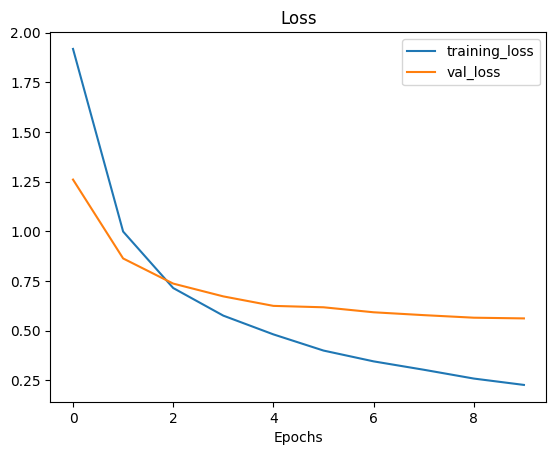

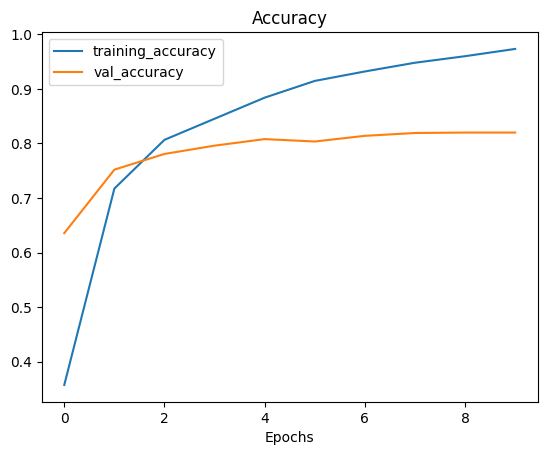

In [11]:
plot_loss_curves(mobilenet_history)

## 2. Name 3 different image classification models on TensorFlow Hub that we haven't used.

1. InceptionV3 - https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3

2. MobileNetV2 - https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2

3. nasnet - https://www.kaggle.com/models/tensorflow/nasnet/tfLite/mobile-metadata/1?tfhub-redirect=true



## 3. Build a model to classify images of two different things you've taken photos of.

* You can use any feature extraction layer from TensorFlow Hub you like for this.

* You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

In [12]:
import zipfile

!wget "https://www.dropbox.com/scl/fi/zd4ygrghs0ckg8kdfkurp/flowers.zip?rlkey=1hcgpmnhvog6vuajd7vbyqkyz&st=faeks6u2&dl=0"

# Rename the file
!mv "flowers.zip?rlkey=1hcgpmnhvog6vuajd7vbyqkyz&st=faeks6u2&dl=0" "flowers.zip"

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("flowers.zip")
zip_ref.extractall()
zip_ref.close()


--2024-12-31 05:37:25--  https://www.dropbox.com/scl/fi/zd4ygrghs0ckg8kdfkurp/flowers.zip?rlkey=1hcgpmnhvog6vuajd7vbyqkyz&st=faeks6u2&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5ee9412238a27ac0b26ae85d15.dl.dropboxusercontent.com/cd/0/inline/ChQcqcIDm5Zh9vY_XtYwhnFQGD-i94tWCGKtmQSNlf2ce7JuCPOKwlWPmh7B8zDrS1il2w71fV-4wVDeJr6iER5V-krC-FyjDubKobOyfrHm68aN2gVyQu_yDlIA5jwPeIvpeCum8uBpadsbNtVlLOa0/file# [following]
--2024-12-31 05:37:25--  https://uc5ee9412238a27ac0b26ae85d15.dl.dropboxusercontent.com/cd/0/inline/ChQcqcIDm5Zh9vY_XtYwhnFQGD-i94tWCGKtmQSNlf2ce7JuCPOKwlWPmh7B8zDrS1il2w71fV-4wVDeJr6iER5V-krC-FyjDubKobOyfrHm68aN2gVyQu_yDlIA5jwPeIvpeCum8uBpadsbNtVlLOa0/file
Resolving uc5ee9412238a27ac0b26ae85d15.dl.dropboxusercontent.com (uc5ee9412238a27ac0b26ae85d15.dl.dropboxusercontent.com)... 1

### Creating DataLoaders

In [20]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "flowers/train/"
test_dir = "flowers/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_flowers = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="binary")

print("Testing images:")
test_data_flowers = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="binary")

Training images:
Found 449 images belonging to 2 classes.
Testing images:
Found 891 images belonging to 2 classes.


In [35]:
train_data_flowers[0][1]

array([0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

### Creating models using Tensorflow Hub

In [21]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [36]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_hub.keras_layer import KerasLayer

In [37]:
print(tf.__version__)
print(hub.__version__)

2.15.0
0.16.1


In [43]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1, activation="sigmoid", name="output_layer")
  ])

  return model

In [44]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=2)

In [45]:
# Compile our resnet model
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [46]:
# Let's fit our ResNet model to the data
resnet_history_flowers = resnet_model.fit(train_data_flowers,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_flowers),
                                  validation_data=test_data_flowers,
                                  validation_steps=len(test_data_flowers))

Epoch 1/5
15/15 [==============================] - 15s 570ms/step - loss: 0.4926 - accuracy: 0.7906 - val_loss: 0.4187 - val_accuracy: 0.7924
Epoch 2/5
15/15 [==============================] - 5s 356ms/step - loss: 0.2462 - accuracy: 0.9154 - val_loss: 0.2753 - val_accuracy: 0.8810
Epoch 3/5
15/15 [==============================] - 5s 336ms/step - loss: 0.1734 - accuracy: 0.9510 - val_loss: 0.2515 - val_accuracy: 0.8900
Epoch 4/5
15/15 [==============================] - 5s 312ms/step - loss: 0.1412 - accuracy: 0.9644 - val_loss: 0.2286 - val_accuracy: 0.9035
Epoch 5/5
15/15 [==============================] - 5s 379ms/step - loss: 0.1173 - accuracy: 0.9644 - val_loss: 0.2325 - val_accuracy: 0.8956


In [47]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

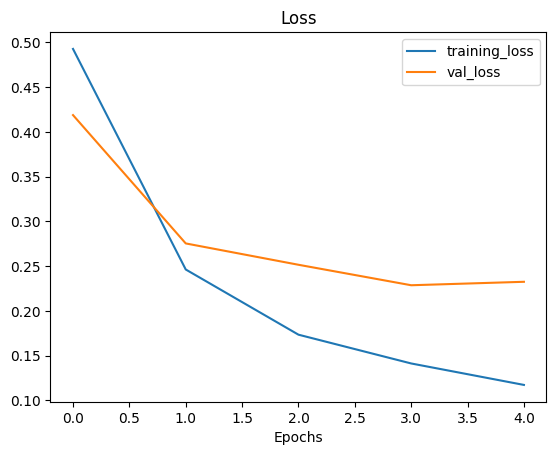

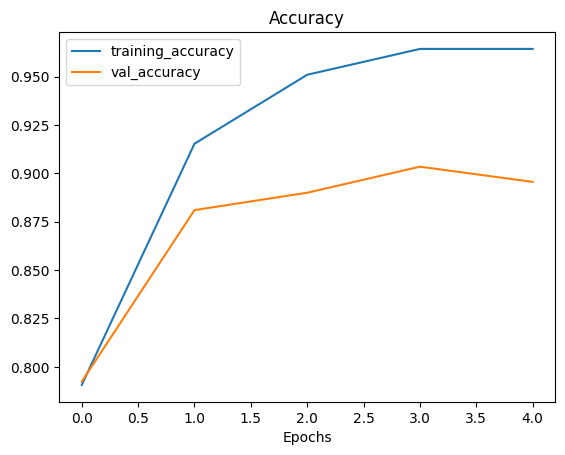

In [48]:
plot_loss_curves(resnet_history_flowers)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [49]:
# Create EfficinetNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=2)

# Compile EfficinetNetB0 model
efficientnet_model.compile(loss="binary_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the EfficientNet model
efficientnet_history_flowers = efficientnet_model.fit(train_data_flowers,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_flowers),
                                              validation_data=test_data_flowers)

Epoch 1/5
15/15 [==============================] - 18s 591ms/step - loss: 0.4867 - accuracy: 0.8441 - val_loss: 0.3482 - val_accuracy: 0.9360
Epoch 2/5
15/15 [==============================] - 5s 320ms/step - loss: 0.2702 - accuracy: 0.9577 - val_loss: 0.2438 - val_accuracy: 0.9618
Epoch 3/5
15/15 [==============================] - 4s 292ms/step - loss: 0.1877 - accuracy: 0.9822 - val_loss: 0.1920 - val_accuracy: 0.9708
Epoch 4/5
15/15 [==============================] - 5s 351ms/step - loss: 0.1443 - accuracy: 0.9866 - val_loss: 0.1649 - val_accuracy: 0.9753
Epoch 5/5
15/15 [==============================] - 4s 312ms/step - loss: 0.1198 - accuracy: 0.9866 - val_loss: 0.1457 - val_accuracy: 0.9764


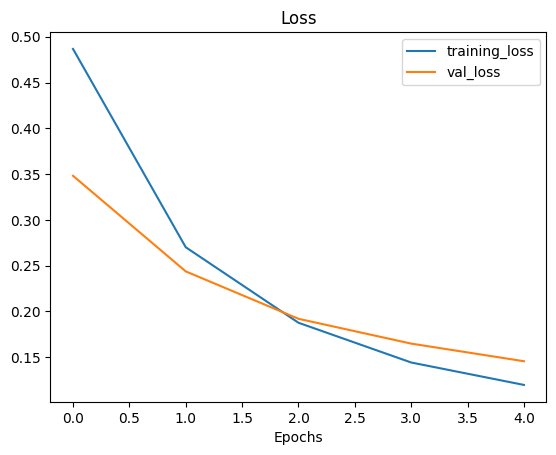

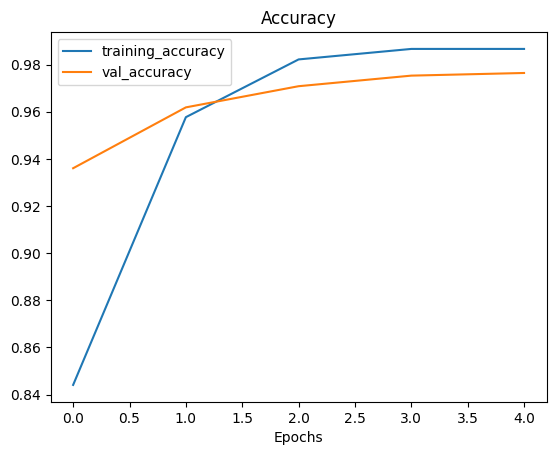

In [50]:
plot_loss_curves(efficientnet_history_flowers)